# Problem Description
In this problem, you will forecast the outcome of a portfolio of loans. Each loan is scheduled to be repaid over 3 years and is structured as follows:

#### Dataset
Each row corresponds to a loan, and the columns are defined as follows:

- The column with header `days since origination` indicates the number of days that elapsed between origination and the date when the data was collected.
- For loans that charged off before the data was collected, the column with header `days from origination to chargeoff` indicates the number of days that elapsed between origination and chargeoff.

#### Goal
We would like you to estimate **what fraction of these loans will have charged off by the time all of their 3-year terms are finished**.

# Exploratory Data Analysis
## Feature Engineering
#### Load libraries & Read data

In [1]:
%matplotlib inline
import pandas as pd
import numpy as np
from numpy import nan
import matplotlib.pyplot as plt
import scipy
import seaborn as sns
from scipy.optimize import curve_fit

In [2]:
data = pd.read_csv('loan_timing.csv', header = 0)

Now I created a new column called **`chargeoff`** which is a dummy variable, where 1 means that loan has charged off and 0 otherwise. This can be used as the response variable if we want to build a model later.

I also created a column called **`prop`**, which stores the fraction of loans that have charged off within that value of `days since origination`. For example, if `days since origination` equals 360, then 

$$prop = \frac{\text{number of chargeoffs with `days since origination`} < 360}{\text{number of total loans with `days since origination`}< 360}$$.

In [3]:
# new column
data['chargeoff'] = np.where(data['days from origination to chargeoff'] >= 0, 1, 0)

# another new column
prop = []
for index, row in data.iterrows():
    prop.append(float(data[(data["days since origination"] <= row["days since origination"]) & (data["chargeoff"] == 1)].shape[0])/float(data[data["days since origination"] <= row["days since origination"]].shape[0]))
    
data["prop"] = prop

Now let's look at part of the dataset. Take record 15 as an example, `prop = 0.0398` means among those loans with `days since origination` less than or equal to 400, 3.98% of them have charged off.

In [4]:
data[11:16]

,days since origination,days from origination to chargeoff,chargeoff,prop
11,336,NaN,0,0.034858
12,51,NaN,0,0.006342
13,117,NaN,0,0.013592
14,327,78.0,1,0.033879
15,400,390.0,1,0.039781


## Simple Visualizations
#### What percentage of loans have been charged off when the data was collected?
We can tell that 3305 out of 50000 loans have been charged off, which is about 6.7%. 

In [5]:
float(data[data["chargeoff"] == 1].shape[0])/ float(data.shape[0])

0.0661

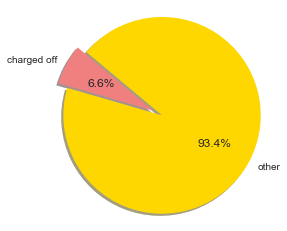

In [30]:
# pie chart
fig, ax = plt.subplots(figsize = (6, 6))
labels = "charged off", "other"
sizes = [3305, 50000 - 3305]
colors = ['lightcoral', 'gold']
explode = (0.1, 0) # explode chargedoff

plt.pie(sizes, explode = explode, labels = labels, colors = colors,
       autopct = '%1.1f%%', shadow = True, startangle = 140)
plt.axis('equal')
plt.show()

#### Chargeoff vs. `days from origination to chargeoff`

Let's also have a look at the distribution of `days from origination to chargeoff`. It seems that the number of chargeoff loans decreases as `days from origination to charge off` increases. However, it doesn't give us too much useful information because we would like to predict the fraction of future chargeoff loans, where we don't have information of `days from origination` at this stage. 

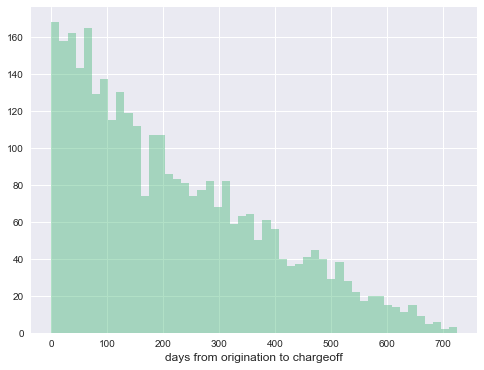

In [7]:
plt.figure(figsize = (8, 6))
sns.distplot(data[data["chargeoff"] == 1]["days from origination to chargeoff"], 
             bins = 50, kde = False, color = "mediumseagreen")
plt.xlabel('days from origination to chargeoff', fontsize = 12)
plt.show()

#### Chargeoff vs. `days since origination`

It seems that the number of chargeoff loans increases as `days since origination` increases. This is useful information for predicting future fraction.

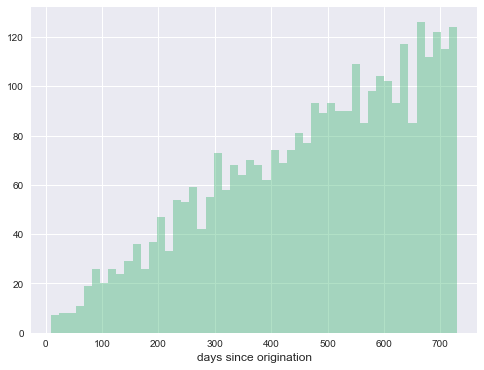

In [8]:
# distribution of loans that charge off
plt.figure(figsize = (8, 6))
sns.distplot(data[data["chargeoff"] == 1]["days since origination"], 
             bins = 50, kde = False, color = "mediumseagreen")
plt.xlabel('days since origination', fontsize = 12)
plt.show()

#### Chargeoff proportion vs. Days since origination
Now let's explore the relationship between our newly created variable: chargeoff proportion and the `days since origination`, which is the information we have for each record.

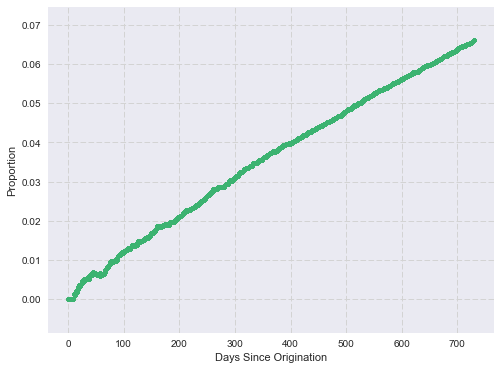

In [9]:
fig, ax = plt.subplots(figsize = (8, 6))
x = data['days since origination']
y = data['prop']
plt.scatter(x, y, s = 10, color = "mediumseagreen")

plt.xlabel('Days Since Origination')
plt.ylabel('Proportion')
plt.grid(color = 'lightgray', linestyle = '--')
plt.show()

We could see an almost perfect linear relationship between the two. One thing we could try is simple linear regression. Besides this, some other techniques could also be applied which I will discuss later in the notebook.

#### Chargeoff proportion vs. Days from origination to chargeoff

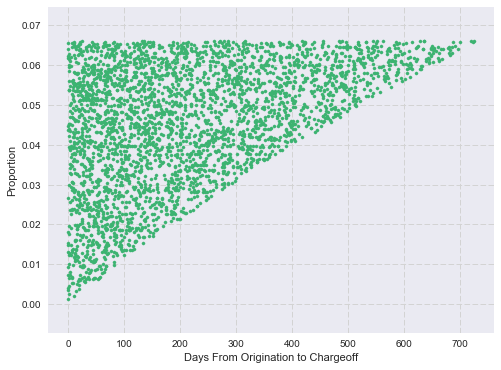

In [10]:
fig, ax = plt.subplots(figsize = (8, 6))
x = data['days from origination to chargeoff']
y = data['prop']
plt.scatter(x, y, s = 10, color = "mediumseagreen")

plt.xlabel('Days From Origination to Chargeoff')
plt.ylabel('Proportion')
plt.grid(color = 'lightgray', linestyle = '--')
plt.show()

I don't see a significant relationship through the scatter plot. And it verifies our conclusion earlier: since we don't have `days from origination to chargeoff` for each record, I won't use this information.

# Model
## Cross-Validation
I only have a single data set here, yet I still want to quantify the quality of a particular fit. In this case, I employ the scikit learn libraries cross-validation implementation, where I split the dataset into a training sample and a testing sample. The training data are used to construct the model, and the testing data quantify the quality of the fit. Here I split our data 60: 40 into training and testing data (60% of the data for training and 40% for testing), before computing a linear regression and visually analyzing the result.

In [11]:
from sklearn.cross_validation import train_test_split
x = data['days since origination']
y = data['prop']
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size = 0.4, random_state = 0)

/anaconda/lib/python2.7/site-packages/sklearn/cross_validation.py:44: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. Also note that the interface of the new CV iterators are different from that of this module. This module will be removed in 0.20.
  "This module will be removed in 0.20.", DeprecationWarning)


## Simple Linear Regression
### Fit the model & Prediction
Continue with the result that I found earlier through the scattor plot, the response is `proportion`, and the only predictor is `days since origination`.

Since this is a regression problem with numeric target variable, the metric I chose is MSE - mean squared error between the prediction and actual value.

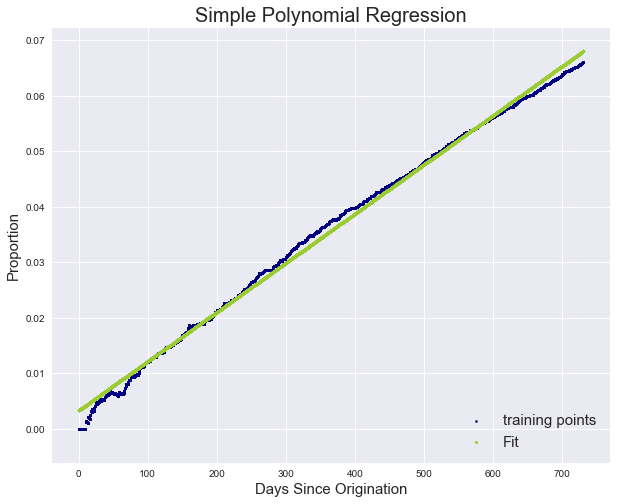

y = 3.296e-03 + 8.868e-05 x
MSE = 1.267e-06
Our prediction of chargeoff fraction = 10.04%


In [13]:
from sklearn.linear_model import LinearRegression

model = LinearRegression()
model.fit(x_train[:, np.newaxis], y_train)

# Plot the data and the model prediction
yf = model.predict(x_test[:, np.newaxis])

plt.figure(figsize = (10, 8))
plt.scatter(x_train, y_train, color = "navy", s = 5, marker = 'o', label = "training points")
plt.scatter(x_test, yf, s = 8, color = "yellowgreen", label = "Fit")

# settings
plt.xlabel('Days Since Origination', fontsize = 15)
plt.ylabel('Proportion', fontsize = 15)
plt.title('Simple Polynomial Regression', fontsize = 20)

plt.legend(loc = 4, fontsize = 15)
sns.despine(offset = 0, trim = True)

plt.show()

print("y = %.3e + %.3e x" % (model.intercept_, model.coef_[0]))
print("MSE = %.3e" % (np.mean((yf - y_test)**2)))
print("Our prediction of chargeoff fraction = " '{percent:.2%}'.format(percent = model.predict(365 * 3)[0]))


The blue points are the training set, yellow points are the test set, red line is our model fit.

According to the problem description, I assume 3-year terms is 365 * 3 days, and the prediction is 10.04%.

### Fit Metrics
The scikit learn library provides several functions that can be used to obtain metrics that quantify the quality of the model fit. For the regression fit, we can use the ***mean absolute error*** and the ***mean squared error***. The second metric can also be used to compute the ***root mean squared error***.

Note that `MSE = 1.267e-06`, which matches the manual calculation.

In [14]:
from sklearn import metrics

print("MAE = %.3e" % (metrics.mean_absolute_error(y_test, yf)))
print("MSE = %.3e" % (metrics.mean_squared_error(y_test, yf)))
print("RMSE = %.3e" % (np.sqrt(metrics.mean_squared_error(y_test, yf))))

MAE = 8.821e-04
MSE = 1.267e-06
RMSE = 1.126e-03


## Simple Polynomial Fitting
From the fitted regression line above, I notice there are some points where the line doesn't fit very well. So I consider fitting the data with a polynomial of n_degree by using different models.

I tried Ridge, Lasso and Elastic Net regression, however, only Ridge regression performs well, so I will only keep part of other models only for illustration.

In [15]:
from sklearn.linear_model import Ridge, Lasso
from sklearn.preprocessing import PolynomialFeatures
from sklearn.pipeline import make_pipeline

### Ridge Regression
#### Second Order

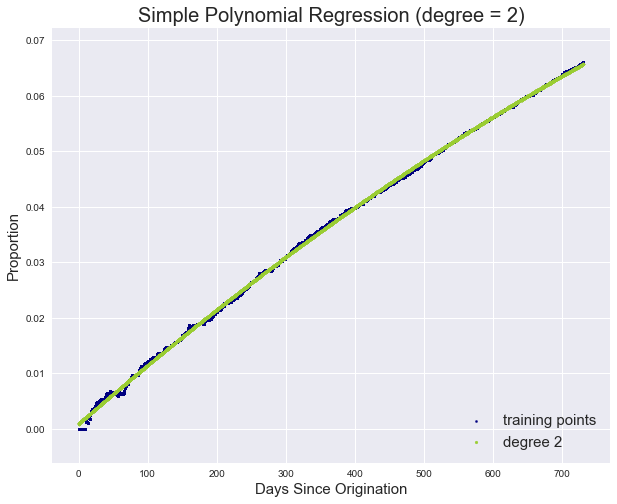

Degree = 2
MAE = 3.228e-04
MSE = 1.809e-07
RMSE = 4.253e-04
Our prediction of chargeoff fraction = 8.75%


In [16]:
plt.figure(figsize = (10, 8))
plt.scatter(x_train, y_train, color = "navy", s = 5, marker = 'o', label = "training points")

model = make_pipeline(PolynomialFeatures(2), Ridge())
model.fit(x_train[:, np.newaxis], y_train)
yf = model.predict(x_test[:, np.newaxis])

plt.scatter(x_test, yf, color = "yellowgreen", label = "degree %d" % 2, s = 8)

# settings
plt.xlabel('Days Since Origination', fontsize = 15)
plt.ylabel('Proportion', fontsize = 15)
plt.title('Simple Polynomial Regression (degree = 2)', fontsize = 20)

plt.legend(loc = 4, fontsize = 15)
sns.despine(offset = 0, trim = True)

plt.show()

print("Degree = %d" % (2))
print("MAE = %.3e" % (metrics.mean_absolute_error(y_test, yf)))
print("MSE = %.3e" % (metrics.mean_squared_error(y_test, yf)))
print("RMSE = %.3e" % (np.sqrt(metrics.mean_squared_error(y_test, yf))))
print("Our prediction of chargeoff fraction = " '{percent:.2%}'.format(percent = model.predict(365 * 3)[0]))

#### Third Order

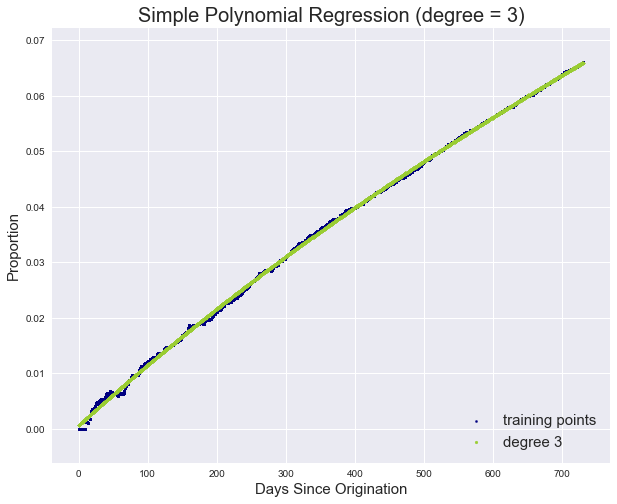

Degree = 3
MAE = 3.050e-04
MSE = 1.698e-07
RMSE = 4.120e-04
Our prediction of chargeoff fraction = 9.24%


In [17]:
plt.figure(figsize = (10, 8))
plt.scatter(x_train, y_train, color = "navy", s = 5, marker = 'o', label = "training points")

model = make_pipeline(PolynomialFeatures(3), Ridge())
model.fit(x_train[:, np.newaxis], y_train)
yf = model.predict(x_test[:, np.newaxis])

plt.scatter(x_test, yf, color = "yellowgreen", label = "degree %d" % 3, s = 8)

# settings
plt.xlabel('Days Since Origination', fontsize = 15)
plt.ylabel('Proportion', fontsize = 15)
plt.title('Simple Polynomial Regression (degree = 3)', fontsize = 20)

plt.legend(loc = 4, fontsize = 15)
sns.despine(offset = 0, trim = True)

plt.show()

print("Degree = %d" % (3))
print("MAE = %.3e" % (metrics.mean_absolute_error(y_test, yf)))
print("MSE = %.3e" % (metrics.mean_squared_error(y_test, yf)))
print("RMSE = %.3e" % (np.sqrt(metrics.mean_squared_error(y_test, yf))))
print("Our prediction of chargeoff fraction = " '{percent:.2%}'.format(percent = model.predict(365 * 3)[0]))

Second-order and third-order polynomial fitting with ridge regression give similar MSE. Then let's look at an extreme case.
#### 10th Order

I also look at an extreme case with degree = 10, which tends to overfit the data.

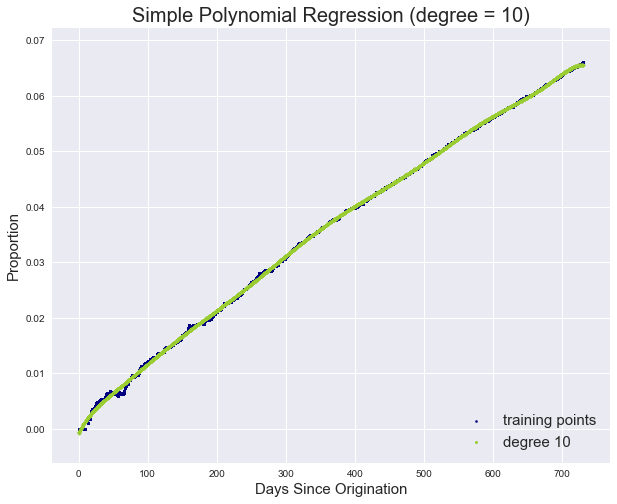

Degree = 10
MAE = 2.201e-04
MSE = 1.016e-07
RMSE = 3.188e-04
Our prediction of chargeoff fraction = -7232.93%


In [18]:
plt.figure(figsize = (10, 8))
plt.scatter(x_train, y_train, color = "navy", s = 5, marker = 'o', label = "training points")

model = make_pipeline(PolynomialFeatures(10), Ridge())
model.fit(x_train[:, np.newaxis], y_train)
yf = model.predict(x_test[:, np.newaxis])

plt.scatter(x_test, yf, color = "yellowgreen", label = "degree %d" % 10, s = 8)

# settings
plt.xlabel('Days Since Origination', fontsize = 15)
plt.ylabel('Proportion', fontsize = 15)
plt.title('Simple Polynomial Regression (degree = 10)', fontsize = 20)

plt.legend(loc = 4, fontsize = 15)
sns.despine(offset = 0, trim = True)

plt.show()

print("Degree = %d" % (10))
print("MAE = %.3e" % (metrics.mean_absolute_error(y_test, yf)))
print("MSE = %.3e" % (metrics.mean_squared_error(y_test, yf)))
print("RMSE = %.3e" % (np.sqrt(metrics.mean_squared_error(y_test, yf))))
print("Our prediction of chargeoff fraction = " '{percent:.2%}'.format(percent = model.predict(365 * 3)[0]))

Although the green line perfectly fits the training points, the model **overfits** the data, which can be reflected from the negative prediction values which was impossible in our case.

### Lasso Regression
#### Second order
As I mentioned, I also tried second-order polynomial regression using Lasso/Elastic Net. Neither of them produce reasonable results.

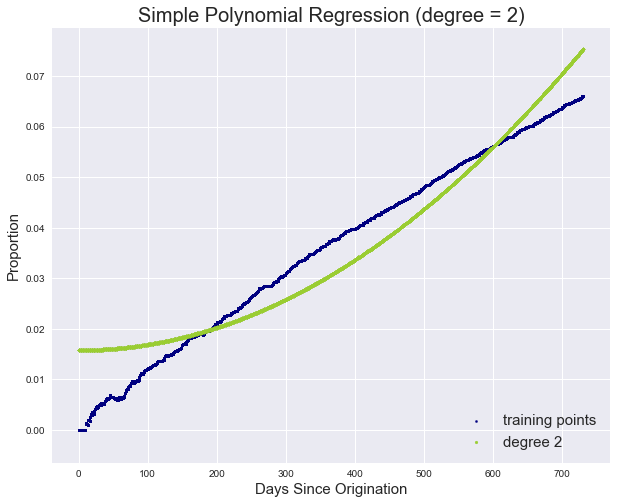

Degree = 2
MAE = 4.763e-03
MSE = 3.229e-05
RMSE = 5.682e-03
Our prediction of chargeoff fraction = 14.98%


In [19]:
plt.figure(figsize = (10, 8))
plt.scatter(x_train, y_train, color = "navy", s = 5, marker = 'o', label = "training points")

model = make_pipeline(PolynomialFeatures(2), Lasso())
model.fit(x_train[:, np.newaxis], y_train)
yf = model.predict(x_test[:, np.newaxis])

plt.scatter(x_test, yf, color = "yellowgreen", label = "degree %d" % 2, s = 8)

# settings
plt.xlabel('Days Since Origination', fontsize = 15)
plt.ylabel('Proportion', fontsize = 15)
plt.title('Simple Polynomial Regression (degree = 2)', fontsize = 20)

plt.legend(loc = 4, fontsize = 15)
sns.despine(offset = 0, trim = True)

plt.show()

print("Degree = %d" % (2))
print("MAE = %.3e" % (metrics.mean_absolute_error(y_test, yf)))
print("MSE = %.3e" % (metrics.mean_squared_error(y_test, yf)))
print("RMSE = %.3e" % (np.sqrt(metrics.mean_squared_error(y_test, yf))))
print("Our prediction of chargeoff fraction = " '{percent:.2%}'.format(percent = model.predict(365 * 3)[0]))

## K Nearest Neighbor Regressor
Since this is a clean dataset with only one predictor, the first machine learning method I tried was KNN, which is regression based on k-nearest neighbors. The target is predicted by local interpolation of the targets associated of the nearest neighbors in the training set.

Reference: http://scikit-learn.org/stable/modules/generated/sklearn.neighbors.KNeighborsRegressor.html

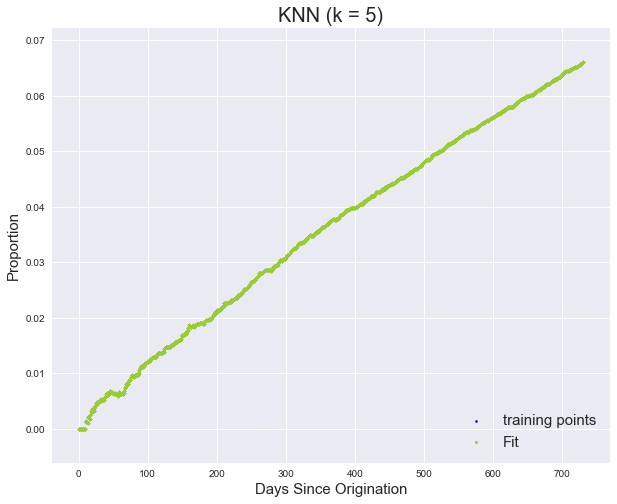

Model: KNN
MAE = 6.301e-19
MSE = 3.789e-36
RMSE = 1.946e-18
Our prediction of chargeoff fraction = 6.61%


In [20]:
from sklearn.neighbors import KNeighborsRegressor

neigh = KNeighborsRegressor(n_neighbors = 5)
neigh.fit(x_train[:, np.newaxis], y_train)
yf = neigh.predict(x_test[:, np.newaxis])

plt.figure(figsize = (10, 8))
plt.scatter(x_train, y_train, color = "navy", s = 5, marker = 'o', label = "training points")
plt.scatter(x_test, yf, color = "yellowgreen", label = "Fit", s = 8)

# settings
plt.xlabel('Days Since Origination', fontsize = 15)
plt.ylabel('Proportion', fontsize = 15)
plt.title('KNN (k = 5)', fontsize = 20)

plt.legend(loc = 4, fontsize = 15)
sns.despine(offset = 0, trim = True)

plt.show()

print("Model: KNN")
print("MAE = %.3e" % (metrics.mean_absolute_error(y_test, yf)))
print("MSE = %.3e" % (metrics.mean_squared_error(y_test, yf)))
print("RMSE = %.3e" % (np.sqrt(metrics.mean_squared_error(y_test, yf))))
print("Our prediction of chargeoff fraction = " '{percent:.2%}'.format(percent = neigh.predict(365 * 3)[0]))

In [29]:
neigh.predict(1000)

array([ 0.0661])

It produces the smallest MSE/ RMSE, which means it predicts the test data very well. However, KNN is based on the neighbors around that data point, we don't have more data points around 365 * 3, which means all predictions will be 0.0661 after the maximum value (730) in our training set.

I also tried different number of neighbors instead of 5, the results are very similar.

# Summary
## Model Selection
Besides KNN, I also tried other machine learning methods such as SVR (support vector regressor) and DecisionTreeRegressor. The modeling process proceeds similarly. 

Although there are a lot of models to try, we should still consider the **simplicity** and the **interpretability** of the model. In this case, I will stick with simple linear/ polynomial regression.

|             Model              |  Test MSE  | Prediction|
|:------------------------------:|:----------:|:---------:|
| Simple Linear Regression       | 1.267e-06  | 10.04%    |
| <span style="color:blue">Second-order polynomial (ridge)</span>| 1.809e-07  | 8.75%    |
| <span style="color:blue">Third-order polynomial (ridge)</span>| 1.698e-07 | 9.24%    |
| 10th-order polynomial (ridge)   | 1.016e-07  | -7232.93% (**seriously overfitting**) |
| Second-order polynomial (Lasso)       | 3.229e-05 | 14.98%  |
| K-Nearest Neighbors(k=5)   | 3.789e-36  | 6.61%    |

## Prediction
To estimate what fraction of these loans will have charged off by the time all of their 3-year terms are finished, I assume the `days since origination` is $365\times 3 = 1095$.

Like I said before, the fraction will be about ***8.75% to 9.24%***. If we allow more error and pursue a simpler model, using simple linear regression is fine, which gives the estimation of 10.04%.

## Sidenote
These are some of my analysis and thoughts of the dataset, I'm sure you must have better solutions. Please don't hesitate to share any insights with me no matter you'd like to hire me or not, I would be really appreciated!